# Adam Thomson - PHY 573 - Genomic Grover Search

The goal of this project is to demonstrate the ability for Grover's algorithm to perform simple bioinformatic queries. I will do this by first examining why genomic sequence searching is an appropriate application of Grover's algorithm, and a thorough instruction for a trivial example. I will then focus on how to construct the oracle gate for a given genomic query, as well as the full quantum circuit to implement the algorithm. I finish the demonstration by comparing the results from more complex queries when running on a local simulator vs. real hardware. The demonstration will conclude with thoughts about the current limitations of this approach and what the future may hold for the potential field of quantum bioinformatics!

In [1]:
# Import libraries
from IPython.display import Math, HTML
import math

# Imports from Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution, plot_histogram

# Imports from Qiskit Runtime for running on real hardware
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Import local constants and utils
from constants import REFERENCE_GENOMES, generate_random_sequence

# Declare shortcut function
def dm(x):
    return display(Math(x))

KeyboardInterrupt: 

## Grover's Algorithm

Grover's algorithm, also known as the quantum search algorithm, was originally published as a way to search an “unsorted database…of which just one item satisfies a given condition,”$^{1}$ proving itself to be "significantly faster than any classical algorithm can be."$^{1}$ Since then, Grover and others have developed enhancements to the algorithm;$^{2}$ for this notebook I will leverage the ability to search for potentially multiple items satisfying the condition. Vazirani provides a timeless comparison for what this algorithm does,$^{3}$ trying to find a needle in a haystack. A classical computer's approach is to scan every object in the stack until coming across the needle, which may require checking the entire haystack. But Grover's quantum approach is like "using a giant magnet so...you find your needle very quickly."$^{3}$ On average, the classical approach requires (N/2) steps to find the solution, while the quantum algorithm will find it in √N steps!

The quantum search algorithm has the potential for profound implications in many fields of research, such as biophysics and chemistry, leading to advancements in medical devices and pharmaceuticals. Shortly after Grover published his algorithm, Hollenberg showed how it could be applied to "protein sequence analysis"$^{4}$ and envisioned the same approach scaled up for "nucleotide sequence comparison in DNA."$^{4}$ In this notebook, I will demonstrate exactly that.

However, let's first examine exactly how the algorithm performs so much better than the classical counterpart.

In [3]:
# Describe the problem statement
dm(r"\text{Say you have a function } U_\omega \text{ such that }")
dm(r"""U_\omega(x) = \begin{cases}
0 &\text{for } x \neq \omega \\
1 &\text{for } x = \omega
\end{cases}""")
dm(r"\text{Where } 0 \leq x \leq (N-1), N = 2^n")
dm(r"\text{We want to find } \omega")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The quantum approach has 3 components: setup, the oracle function, and the diffusion operator.
The initial setup only happens once, and then the oracle and diffusion operator are repeated a number of times dependent on the problem.
Construction of the oracle function is unimportant for the sake of the algorithm, only that it phase flips the correct qubits.
The diffusion operator will then perform 'inversion about the mean' to amplify the desired state(s) while dampening all others.
Finally, after enough iterations, we measure the qubits and check the answer to verify the result.

In [4]:
# State initialization
dm(r"\text{The algorithm setup is one that many quantum algorithms use, putting all input qubits into a uniform superposition.}")
dm(r"\text{This is achieved by applying a Hadamard gate to all qubits.}")
dm(r"\ket{\psi_0} = \ket{00..0}")
dm(r"\ket{\psi_0'} = H^{\otimes n} \ket{\psi_0} = (H\ket0) \otimes (H\ket0) \otimes ... (H\ket0)")
dm(r"\qquad = \frac1{\sqrt2}(\ket{0} + \ket{1}) \otimes \frac1{\sqrt2}(\ket{0} + \ket{1}) \otimes ... \frac1{\sqrt2}(\ket{0} + \ket{1})")
dm(r"\qquad = \frac1{2^{\frac{n}{2}}} (\ket{0} + \ket{1})^{\otimes n}")
dm(r"\ket{\psi_0'} = \frac1{\sqrt{N}} \sum_{x=0}^{N-1} \ket{x}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
# Apply the oracle operator
dm(r"\text{The oracle operator will then perform a phase flip on the qubits corresponding to a solution state.}")
dm(r"\ket{\psi_0''} = U_\omega \ket{\psi_0'}")
dm(r"""\qquad = \frac1{\sqrt{N}} \sum_{x=0}^{N-1} \begin{cases}
\ket{x} &\text{for } x \neq \omega \\
-\ket{x} &\text{for } x = \omega
\end{cases}""")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
# Apply the diffusion operator
dm(r"\text{And the diffusion operator will amplify the state } \ket{\omega} \text{ as well as dampen all other } \ket{x}")
dm(r"U_s = 2\ket{s} \bra{s} - 1 \text{; Where } \ket{s} = H^{\otimes n}\ket{0}_n")
dm(r"\ket{\psi_1} = U_s \ket{\psi_0''} = U_s U_\omega H^{\otimes n} \ket{\psi_0}")
dm(r"\text{Depending on the size of the search space and the number of solutions, now may be a good time to measure. But if not, repeat...}")
dm(r"\ket{\psi_2} = U_s U_\omega \ket{\psi_1} = (U_s U_\omega)^2 H^{\otimes n} \ket{\psi_0}")
dm(r"\ket{\psi_t} = (U_s U_\omega)^t H^{\otimes n} \ket{\psi_0}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
# Describe how to determine optimal t
dm(r"\text{There are multiple ways to approach a calculation for an optimal } t, \text{ with the following equation widely used:}")
dm(r"t = \lfloor \frac{\pi}4 \sqrt{\frac{N}{m}} \rfloor")
dm(r"\text{Where } N \text{ is the size of the search space, while } m \text{ is the number of matches.}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let's examine in detail how these pieces come together for a simple genomic sequence search.

## Example Walkthrough

I'll start by examining each intermediary state in the trivial example of a 4-basepair reference sequence and 1-basepair search string with a single match. In this case, we are attempting to find the index of "A" in the sequence `GCAT`

In [8]:
# We will need 2 qubits to capture all 4 possible indexes for a match
dm(r"\ket{\psi_0} = \ket{00}")

<IPython.core.display.Math object>

In [9]:
# Begin by putting all qubits into a superposition with Hadamard gates
dm(r"\ket{\psi_0'} = (\Eta \otimes \Eta)\ket{\psi_0}")
dm(r"\qquad = (H \otimes H)\ket{00}")
dm(r"\qquad = H \ket0 \otimes H \ket0")
dm(r"\qquad = \frac1{\sqrt2}(\ket0 + \ket1) \otimes \frac1{\sqrt2}(\ket0 + \ket1)")
dm(r"\qquad = \frac12(\ket{00} + \ket{01} + \ket{10} + \ket{11}")


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
# Since "A" is in the 3rd position of GCAT, we know the oracle performs a phase flip for |10>
dm(r"\ket{\psi_0''} = U_\omega \ket{\psi_0'}")
dm(r"\qquad = \frac12(\ket{00} + \ket{01} - \ket{10} + \ket{11})")


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
# Apply the diffusion operator
dm(r"\ket{\psi_1} = U_s \ket{\psi_0''} = (2\ket{s} \bra{s} - 1)\ket{\psi_0''}")
dm(r"\qquad = 2\ket{s}\braket{s|\psi_0''} - \ket{\psi_0''}")
dm(r"\braket{s|\psi_0''} = \frac1{2^2}(1 + 1 - 1 + 1) = \frac12")
dm(r"\ket{\psi_1} = \ket{s} - \ket{\psi_0''}")
dm(r"""\qquad = \frac12(\cancel{\ket{00}} + \cancel{\ket{01}} + \ket{10} + \cancel{\ket{11}})
    - \frac12(\cancel{\ket{00}} + \cancel{\ket{01}} - \ket{10} + \cancel{\ket{11}})""")
dm(r"\ket{\psi_1} = \ket{10}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

With just a single iteration of Grover's algorithm, we have (theoretically) put the qubits into a state with 100% probability of measuring the correct answer |10> = "A"! Recall that A classical computer would take 2.5 attempts on average, with a worst case maximum of 4.

### Utility functions

Before continuing to building circuits, I'll describe some utility functions for the genomic sequence application.

In [4]:
"""
Search the input reference string for instances of the search string(s)
and return indexes for the start of all matches.
"""
def _find_match_indexes(search_seqs, reference, num_qubits):
    # If only searching for a single sequence, convert to list
    if not isinstance(search_seqs, list):
        search_seqs = [search_seqs]
   
    # Initialize list of indexes to be returned
    all_marked_indexes = []
    
    # Loop through all searches, and find all matches for each
    for search_seq in search_seqs:
        # Reset search start index to beginning of reference
        i = 0
        # Continue finding matches until we reach the end of reference
        while i < len(reference):
            try:
                n = reference.index(search_seq, i)
                all_marked_indexes.append(n)
                # Next search will only check the reference after the current match
                i = n + 1
            # Will always eventually hit this when no matches exist in the rest of reference
            except ValueError:
                i = len(reference) + 1
    
    # Convert indexes to 0-padded binary strings
    return [bin(i)[2:].zfill(num_qubits) for i in all_marked_indexes]

In [5]:
"""
Build an oracle gate for a given list of search strings and reference

Parameters:
    base_seqs <str|list>: Sequence(s) being searched for
    reference <str>: Reference being searched

Returns:
    QuantumCircuit: Quantum circuit representing Grover Operator gate
    int: number of matches found
"""
def genomic_oracle_gate(base_seqs, reference):
    # Compute the number of qubits required for circuit, log_2(N) (always round up)
    num_qubits = math.ceil(math.log(len(reference), 2))

    # Initialize quantum circuit with that many qubits
    qc = QuantumCircuit(num_qubits)
    
    # Search the reference for the desired strings and mark the indexes found
    marked_states = _find_match_indexes(base_seqs, reference, num_qubits)
    # Print it out for manual verification
    print(f"Marked the indexes: {marked_states}")
    
    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)

    # Also return the number of marked states found for determining number of iterations
    return qc, len(marked_states)

In [6]:
"""Determine the optimal number of iterations"""
def optimal_num_iterations(match_count, num_qubits):
    # t = floor((pi/4)*(sqrt(N/m))), at least 1
    return max(
        math.floor(
            (math.pi / 4) * (math.sqrt(match_count / 2**num_qubits))
        ), 1)

In [7]:
"""
Given a list of input sequences and a reference, build the full
circuit implementing Grover's algorithm to find indexes of matches
"""
def build_genomic_grover_circuit(search_seqs, ref_str):
    # Figure out how many qubits are needed for the circuit
    nqubits = math.ceil(math.log(len(ref_str), 2))
    qc = QuantumCircuit(nqubits)

    # Initialize by applying Hadamard gates to all qubits
    qc.h(range(nqubits))

    # Build the oracle function and find m
    genomic_oracle, m = genomic_oracle_gate(search_seqs, ref_str)

    # Turn the oracle into a Grover Operator
    genomic_grover = GroverOperator(genomic_oracle, name="Genomic Grover")

    # Compose the circuit
    qc.compose(genomic_grover.power(optimal_num_iterations(m, nqubits**2)), inplace=True)

    qc.measure_all()

    return qc

In [8]:
"""Transpiles a circuit to run locally and returns the sampler counts"""
def run_local(qc, sampler, shots=10000):
    # Transpile and run the example circuit
    transp_qc = transpile(qc, sampler)
    results = sampler.run(transp_qc, shots=shots).result()
    return results.get_counts()


In [9]:
"""Transpiles a circuit to run on real hardware and returns the sampler counts"""
def run_quantum(qc, pm, sampler):
    # Transpile for real hardware
    transp_qc = pm.run(qc)
    
    # Run on real hardware
    sampler.options.default_shots = 1_000
    result = sampler.run([transp_qc]).result()

    # Return the counts
    return result[0].data.meas.get_counts()

## Example Circuit

Now that we can build the circuit, let's see how the theoretical results of the trivial example compare to results.

In [10]:
# Initialize local simulator and setup backend for real hardware
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

sim_sampler = AerSimulator()

# select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name
real_sampler = Sampler(mode=backend)
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

Marked the indexes: ['10']


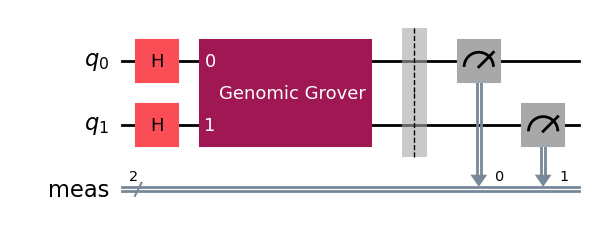

In [19]:
# Setup trivial example
example_ref = REFERENCE_GENOMES['test0']
example_search = ["A"]

example_qc = build_genomic_grover_circuit(example_search, example_ref)
example_qc.draw(output="mpl")

As expected, we only use 1 iteration of the oracle and diffusor before measurement. Let's examine the results on a local simulator and real hardware.

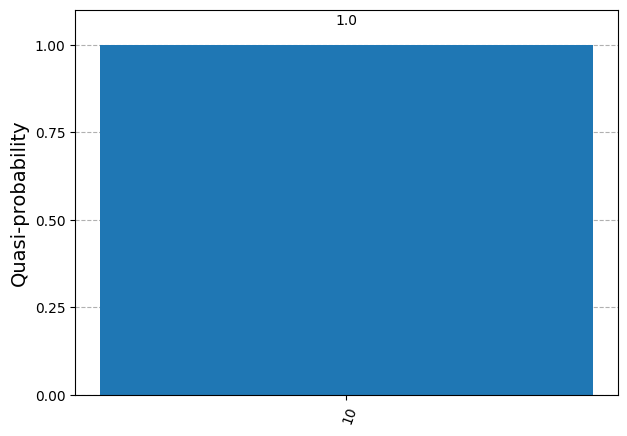

In [65]:
# Transpile and run the example circuit
sim_counts = run_local(example_qc, sim_sampler)
plot_distribution(sim_counts)

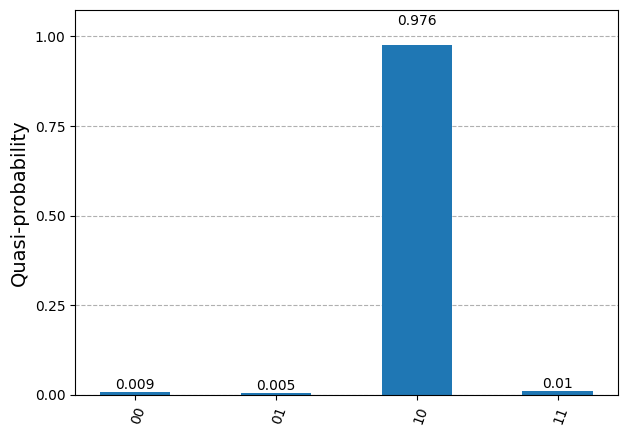

In [21]:
# Run on real hardware to check results
real_counts = run_quantum(example_qc, pm, real_sampler)
plot_distribution(real_counts)

The results align with the equations! In the simulator, we see 100% measurement of |10>; while on real hardware there is a very high probability of measuring |10> and a small chance of measuring other values.

## Experimentation

Now that I've shown a proof of concept, let's try out some more interesting use cases and push the limits of local simulators and real hardware.

Marked the indexes: ['001', '100']


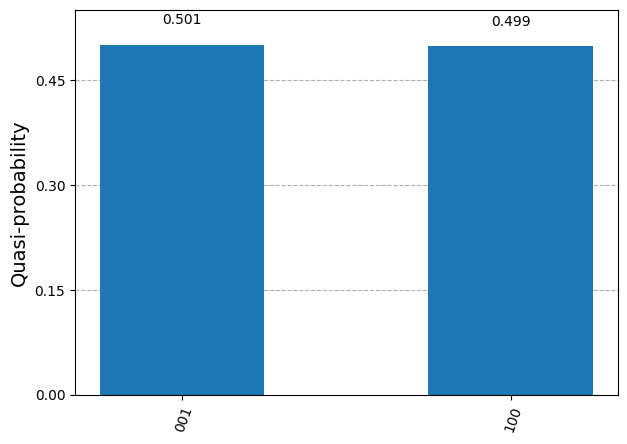

In [66]:
# Tests with GATTACA reference
gattaca_ref = REFERENCE_GENOMES['test1']
gattaca_search = ["AT", "AC"]
# With 2 valid matches, we expect to see |001> and |100> as the likely results

gattaca_qc = build_genomic_grover_circuit(gattaca_search, gattaca_ref)
gattaca_sim_counts = run_local(gattaca_qc, sim_sampler)
plot_distribution(gattaca_sim_counts)

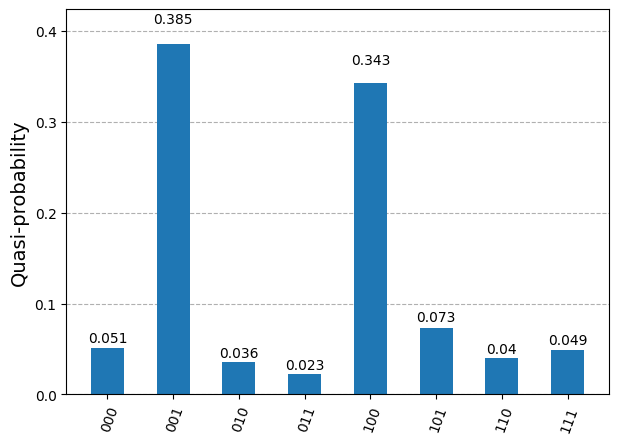

In [32]:
gattaca_q_counts = run_quantum(gattaca_qc, pm, real_sampler)
plot_distribution(gattaca_q_counts)

Our simulator and real results continue to align with theory for a 3-qubit example. Let's try adding more.

In [34]:
# Try a 4-qubit test using random elements
test_ref = REFERENCE_GENOMES['test2']
# set your input string length, and how many to look for
# Default is 2 random 2-chr string
test_search_length, test_num_search = 2, 2
test_search = [
    generate_random_sequence(test_search_length)
    for _ in range(test_num_search)
]

In [25]:
# Provide a way to peek into the test inputs
reveal_secret = f'''
<details>
    <summary>Click here to reveal the secrets!</summary>
    test_reference={test_ref}
    <br/>
    test_search={test_search}
</details>
'''
HTML(reveal_secret)

Marked the indexes: ['0001', '0010']


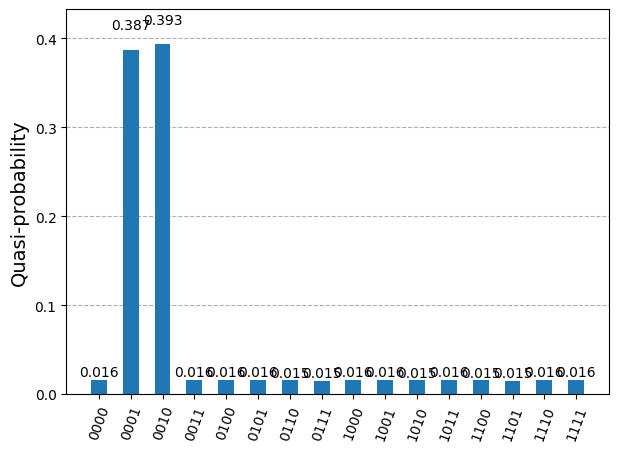

In [67]:
# Create the test circuit and examine results
test_qc = build_genomic_grover_circuit(test_search, test_ref)

test_local = run_local(test_qc, sim_sampler)
plot_distribution(test_local)

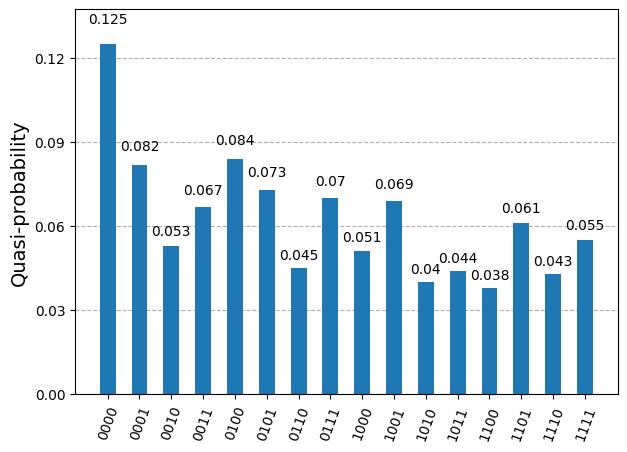

In [36]:
test_q = run_quantum(test_qc, pm, real_sampler)
plot_distribution(test_q)

Uh oh, at 4 qubits the real hardware has started to build up significant error and our desired results are no more likely than the incorrect results even though the simulation clearly shows the states that were marked. Let's see how the simulator continues to perform with more qubits.

In [37]:
# Try a 5-qubit test using random elements
test32_ref = REFERENCE_GENOMES['test32']
# set your input string length, and how many to look for
# Default is 2 random 2-chr string
test32_search_length, test32_num_search = 2, 2
test32_search = [
    generate_random_sequence(test32_search_length)
    for _ in range(test32_num_search)
]

# Provide a way to peek into the test inputs
reveal_32secret = f'''
<details>
    <summary>Click here to reveal the secrets!</summary>
    test_reference={test32_ref}
    <br/>
    test_search={test32_search}
</details>
'''
HTML(reveal_32secret)

Marked the indexes: ['01000', '10110', '11001', '11100', '01010']


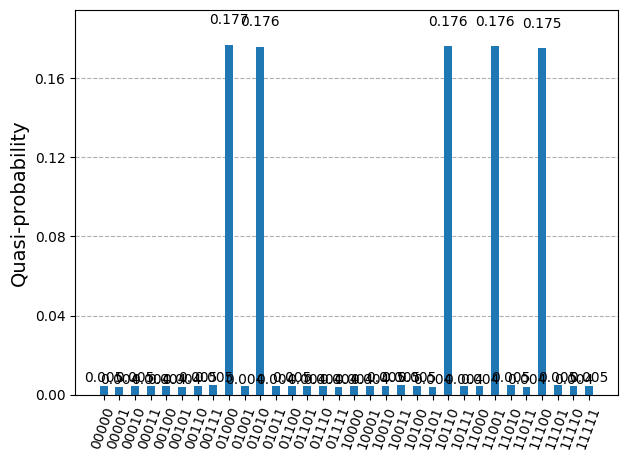

In [68]:
test_32_qc = build_genomic_grover_circuit(test32_search, test32_ref)
test_32_sim = run_local(test_32_qc, sim_sampler)
plot_distribution(test_32_sim)

At this point, adding more qubits means N grows large enough that I need to make 2 changes going forward. Instead of plotting quasi-probability, I will be using raw sampling counts instead. Keep in mind how many shots are used when looking at these counts. Secondly, I will have to truncate the results to only include the top 20 results to more clearly display the results for examination.

In [39]:
# Try a 6-qubit test using random elements
test64_ref = REFERENCE_GENOMES['test64']
# set your input string length, and how many to look for
# Default is 2 random 2-chr string
test64_search_length, test64_num_search = 2, 2
test64_search = [
    generate_random_sequence(test64_search_length)
    for _ in range(test64_num_search)
]

# Provide a way to peek into the test inputs
reveal_64secret = f'''
<details>
    <summary>Click here to reveal the secrets!</summary>
    test_reference={test64_ref}
    <br/>
    test_search={test64_search}
</details>
'''
HTML(reveal_64secret)

Marked the indexes: ['010111', '100111', '101011', '111100', '010000', '010110', '101010', '111101']


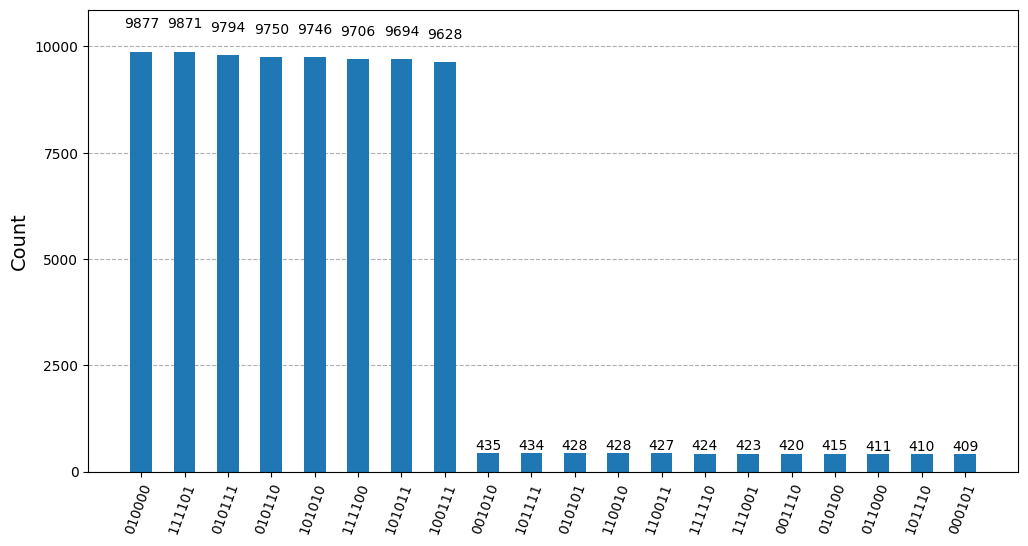

In [97]:
test_64_qc = build_genomic_grover_circuit(test64_search, test64_ref)
test_64_sim = run_local(test_64_qc, sim_sampler, shots=100000)
plot_histogram(test_64_sim, sort='value_desc', number_to_keep=20, figsize=(12, 6))

In [49]:
# What about 8-qubits?
test256_ref = REFERENCE_GENOMES['test256']
# set your input string length, and how many to look for
# Default is 2 random 2-chr string
test256_search_length, test256_num_search = 4, 2
test256_search = [
    generate_random_sequence(test256_search_length)
    for _ in range(test256_num_search)
]

# Provide a way to peek into the test inputs
reveal_256secret = f'''
<details>
    <summary>Click here to reveal the secrets!</summary>
    test_reference={test256_ref}
    <br/>
    test_search={test256_search}
</details>
'''
HTML(reveal_256secret)

In [50]:
test256_qc = build_genomic_grover_circuit(test256_search, test256_ref)

Marked the indexes: ['11010110']


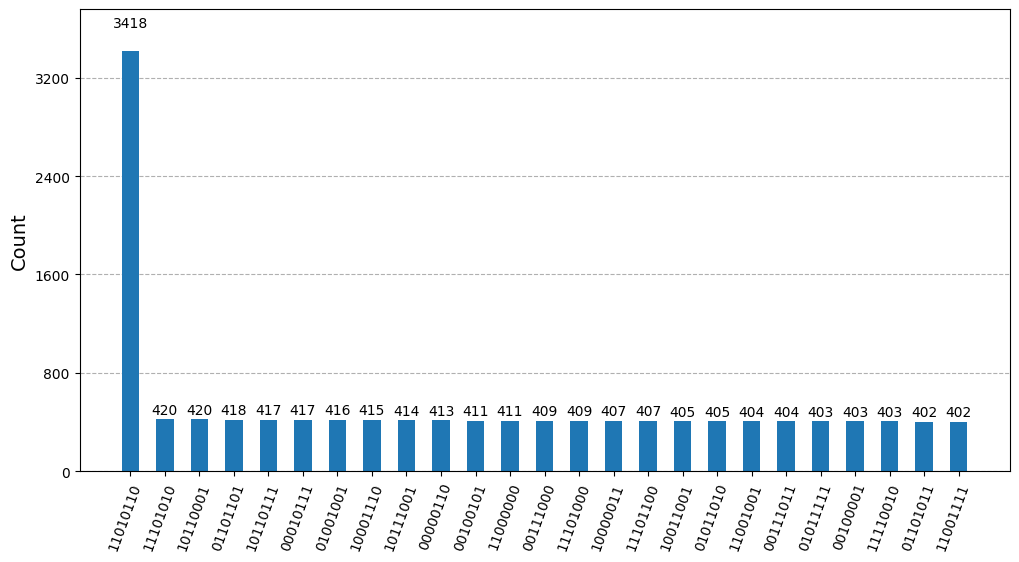

In [98]:
test256_sim = run_local(test256_qc, sim_sampler, shots=100000)
plot_histogram(test256_sim, sort='value_desc', number_to_keep=25, figsize=(12, 6))

At this point, we start to see the true effect of exponential growth of N. While it's true that the probability of measuring the correct result is much higher than any other value, the number of other results means that the correct result has a fairly low probability of measurement. In earlier runs, we could be confident in measuring a correct value in the first handful of samples, but now it will require ~25 attempts before we can be confident in a correct result - still much better than the classical ~125!

In [61]:
# 10-qubits?
test1k_ref = REFERENCE_GENOMES['test1K']
# set your input string length, and how many to look for
# Default is 2 random 5-chr string
test1k_search_length, test1k_num_search = 5, 2
test1k_search = [
    generate_random_sequence(test1k_search_length)
    for _ in range(test1k_num_search)
]

# Provide a way to peek into the test inputs
reveal_1ksecret = f'''
<details>
    <summary>Click here to reveal the secrets!</summary>
    test_reference={test1k_ref}
    <br/>
    test_search={test1k_search}
</details>
'''
HTML(reveal_1ksecret)

In [62]:
test1k_qc = build_genomic_grover_circuit(test1k_search, test1k_ref)


Marked the indexes: ['0010001001', '1001010011', '1101001110', '1101100001', '0111000011']


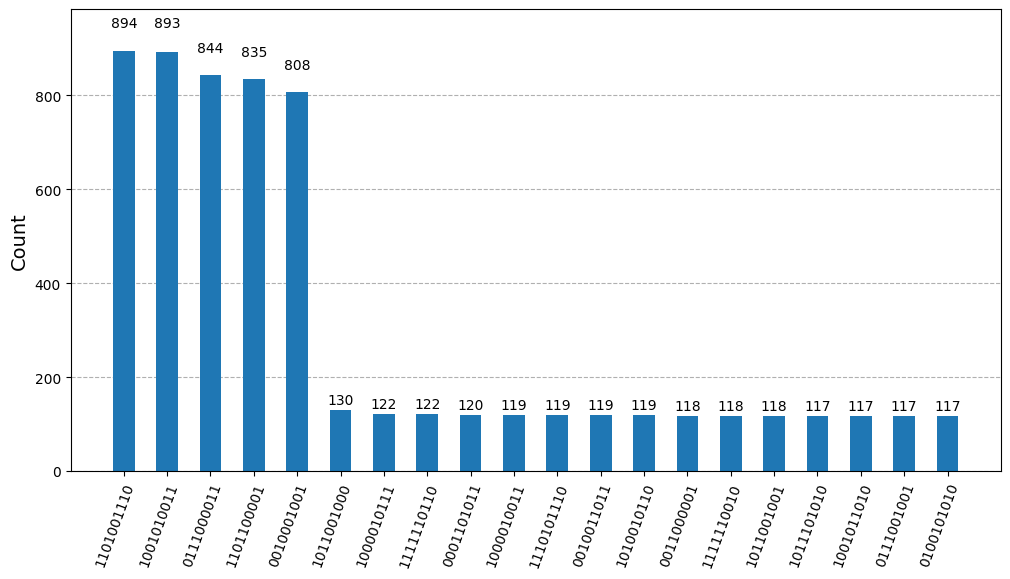

In [100]:
test1k_sim = run_local(test1k_qc, sim_sampler, shots=100000)
plot_histogram(test1k_sim, sort='value_desc', number_to_keep=20, figsize=(12,6))

I leave the calls to run the simulations for these last two circuits commented out for the sake of anyone that clicks "Run All" on this notebook. Make sure you have enough memory and/or patience for these before uncommenting.

In [86]:
# 20 qubits??
test1m_ref = REFERENCE_GENOMES['test1M']
# set your input string length, and how many to look for
# Default is 2 random 10-chr string
test1m_search_length, test1m_num_search = 10, 2
test1m_search = [
    generate_random_sequence(test1m_search_length)
    for _ in range(test1m_num_search)
]

# Provide a way to peek into the test inputs
reveal_1msecret = f'''
<details>
    <summary>Click here to reveal the secrets!</summary>
    test_reference={test1m_ref}
    <br/>
    test_search={test1m_search}
</details>
'''
HTML(reveal_1msecret)

In [87]:
# test1m_qc = build_genomic_grover_circuit(test1m_search, test1m_ref)

Marked the indexes: ['10010101001011000001']


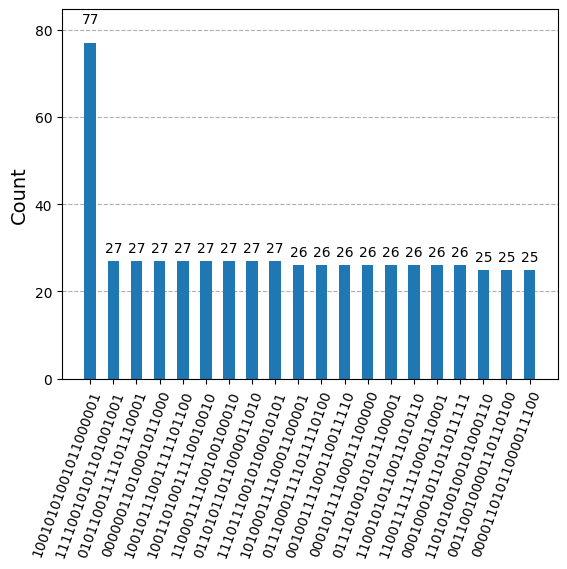

In [101]:
# Need to really crank up the sampler to see significance
test1m_sim = None # run_local(test1m_qc, sim_sampler, shots=10000000)

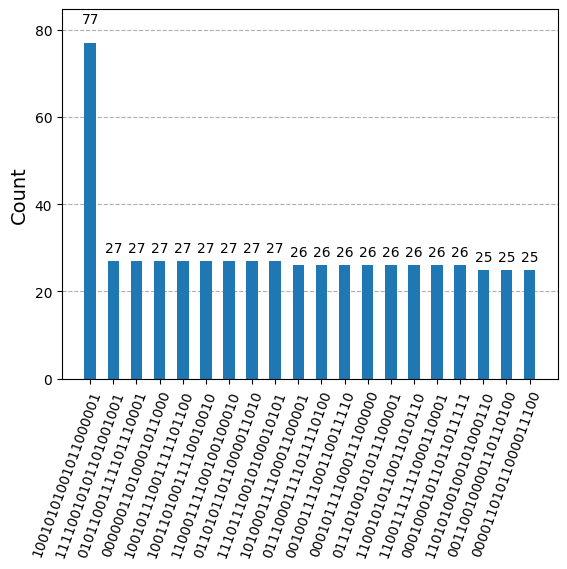

In [102]:
plot_histogram(test1m_sim, sort='value_desc', number_to_keep=20)

In [16]:
# 30-qubits?????
test2b_ref = REFERENCE_GENOMES['test2B']
# set your input string length, and how many to look for
# Default is 2 random 10-chr string
test2b_search_length, test2b_num_search = 10, 2
test2b_search = [
    generate_random_sequence(test2b_search_length)
    for _ in range(test2b_num_search)
]

# Provide a way to peek into the test inputs
reveal_2bsecret = f'''
<details>
    <summary>Click here to reveal the secrets!</summary>
    test_search={test2b_search}
    <br/>
    test_ref={test2b_ref}
</details>
'''
HTML(reveal_2bsecret)

In [15]:
test2b_qc = build_genomic_grover_circuit(test2b_search, test2b_ref)

Marked the indexes: []


In [ ]:
# Maybe go do something else for a while
test2b_sim = None # run_local(test2b_qc, sim_sampler, shots=100000000)

In [ ]:
plot_histogram(test2b_sim, sort='value_desc', number_to_keep=20)

## References

Algorithm implementation based on qiskit tutorial notebook: https://learning.quantum.ibm.com/tutorial/grovers-algorithm 

[1] Grover, L. “A fast quantum mechanical algorithm for database search” Proceedings, 28th Annual ACM Symposium on the Theory of Computing May, 1996 https://doi.org/10.48550/arXiv.quant-ph/9605043

[2] Grover, L., Rudolf, T. “Creating superpositions that correspond to efficiently integrable probability
distributions” 2002 https://doi.org/10.48550/arXiv.2406.13785 

[3] Vazirani, U. "Lecture 11 1 NEEDLE IN A HAYSTACK" 2019, Sandro Mareco, https://youtu.be/-nFbjqYyoEI?list=PLXEJgM3ycgQW5ysL69uaEdPoof4it6seB

[4] Hollenberg, L. “Fast Quantum Search Algorithms in Protein Sequence Comparison - Quantum Biocomputing” 25, Feb 2000 https://doi.org/10.48550/arXiv.quant-ph/0002076 